In [1]:
import numpy as np
from tensorly import kruskal_to_tensor, kron
from tensorly.tenalg import khatri_rao
from sporco.linalg import fftconv, fftn, ifftn
from sporco.metric import snr
from scipy import linalg, signal
from scipy.sparse import csr_matrix, hstack, kron, identity, diags
from scipy.sparse.linalg import eigsh
import time

from TC_FISTA import *

import matplotlib.pyplot as plt
from sporco import plot

Using numpy backend.


In [2]:
import mne
from mne import create_info
Fs=250
ls_channel = ['FP1', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7',
              'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'FP2', 'Fz']
mtg = mne.channels.read_montage("standard_1005", ch_names=ls_channel, unit='cm')
info = create_info(ch_names=ls_channel, montage=mtg, ch_types="eeg", sfreq=Fs)

In [3]:
# Load pre-"trained" model
Z_channel = np.load('./data/Z_channel.npy')
Z_freq = np.load('./data/Z_freq.npy')
Z_time = np.load('./data/Z_time.npy')
D = np.load('./data/D.npy')

# Dimension
N1 = Z_channel.shape[1]
N2 = Z_freq.shape[1]
N3 = Z_time.shape[1]
K = D.shape[0]
R = Z_channel.shape[2]

W1 = D.shape[1]
W2 = D.shape[2]
W3 = D.shape[3]

f1 = np.linspace(0, Fs/2., 513) # frequency bin
t1 = np.linspace(0, 1000, 490) # time bin

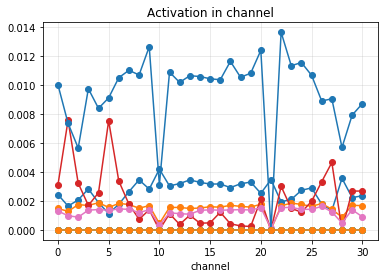

In [4]:
_ = [plt.plot(Z_channel[x], '-o') for x in range(K)]
plt.title('Activation in channel')
plt.xlabel('channel')
plt.grid(alpha=.3)

In [5]:
good_chan = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30]
bad_chan = [10, 21, 28, 31]

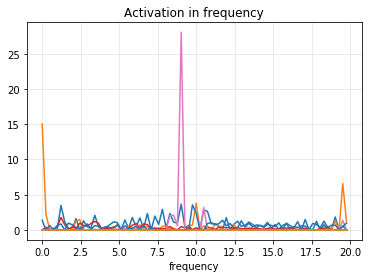

In [6]:
_ = [plt.plot(f1[:np.sum(f1<20)], Z_freq[x]) for x in range(K)]
plt.title('Activation in frequency')
plt.xlabel('frequency')
plt.grid(alpha=.3)

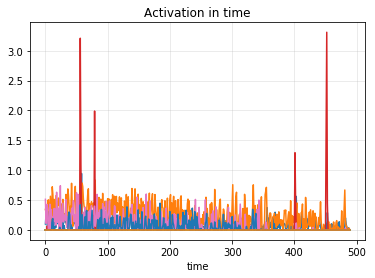

In [7]:
_ = [plt.plot(Z_time[x]) for x in range(K)]
plt.title('Activation in time')
plt.xlabel('time')
plt.grid(alpha=.3)

<Figure size 432x288 with 0 Axes>

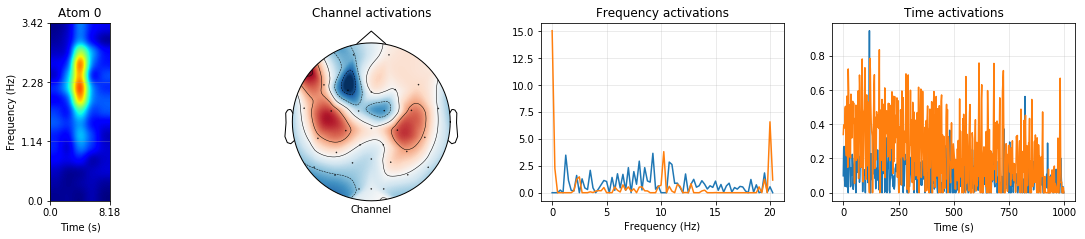

<Figure size 432x288 with 0 Axes>

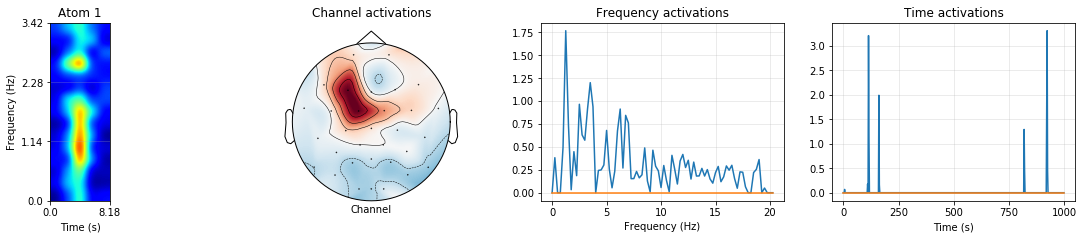

<Figure size 432x288 with 0 Axes>

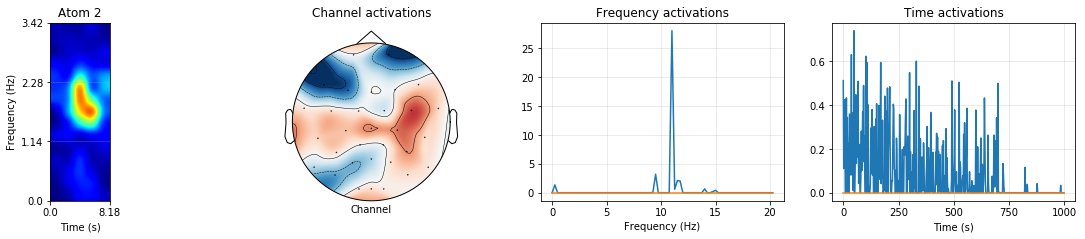

<Figure size 432x288 with 0 Axes>

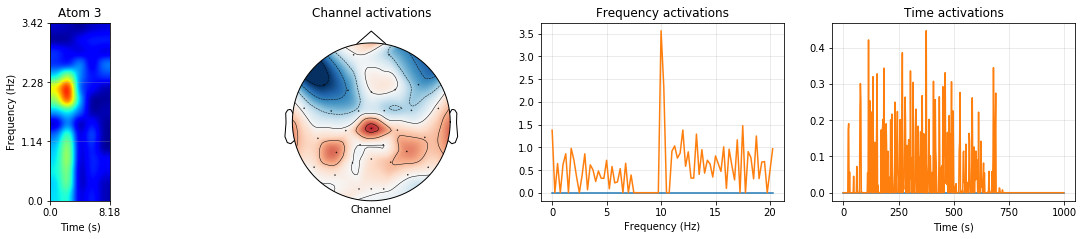

In [8]:
# Visualization of the results

for k in range(K):
    if np.sum(abs(Z_channel[k]) > 0.) and np.sum(abs(Z_freq[k]) > 0) and np.sum(abs(Z_time[k]) > 0):
        plt.figure()
        plt.figure(figsize=(20, 3))
        
        # =========================== Atom
        plt.subplot(141)
        if k == 0 or k == 2:
            plt.imshow(abs(np.roll(D[k, 0], 2)), cmap='jet', aspect='equal', vmax=np.max(abs(D[k])), vmin=np.min(abs(D[k])), interpolation='gaussian')
        else:
            plt.imshow(abs(D[k, 0]), cmap='jet', aspect='equal', vmax=np.max(abs(D[k])), vmin=np.min(abs(D[k])), interpolation='gaussian')
        plt.xticks(np.linspace(-0.5, 4.5, 2), np.round(np.linspace(0., t1[W3-1], 2), 2))
        plt.yticks(np.linspace(-0.5, 14.5, 4), np.round(np.linspace(f1[W2-1], 0., 4), 2))
        plt.grid(alpha=.3)
        plt.title('Atom ' + str(k))
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        
        # =========================== Channel
        plt.subplot(142)
        # plt.plot(Z_channel[k, :, 0])
        # plt.plot(Z_channel[k, :, 1])
        
        n1 = np.zeros(32)
        if k == 0 or k==3:
            n1[:31] = Z_channel[k, :, 1]
        else:
            n1[:31] = Z_channel[k, :, 0]
        
        n1[bad_chan] = np.mean(n1[good_chan])
        mne.viz.plot_topomap(n1-np.mean(n1), info, show=False)
        plt.title('Channel activations')
        plt.xlabel('Channel')
        plt.grid(alpha=0.3)
        
        # =========================== Freq
        plt.subplot(143)
        plt.title('Frequency activations')
        if k == 2:
            plt.plot(np.flip(Z_freq[k, :, 0], axis=0))
            plt.plot(np.flip(Z_freq[k, :, 1], axis=0))
        else:
            plt.plot(Z_freq[k, :, 0])
            plt.plot(Z_freq[k, :, 1])
        plt.xticks((0, 20, 40, 60, 80), np.array(np.round(f1[[0, 20, 40, 60, 80]], 0), dtype=int))
        plt.xlabel('Frequency (Hz)')
        plt.grid(alpha=0.3)
        
        # =========================== Time
        plt.subplot(144)
        plt.plot(Z_time[k, :, 0])
        plt.plot(Z_time[k, :, 1])
        plt.title('Time activations')
        plt.xlabel('Time (s)')
        plt.grid(alpha=0.3)
        plt.xticks(np.linspace(0, N3, 5), (0, 250, 500, 750, 1000))

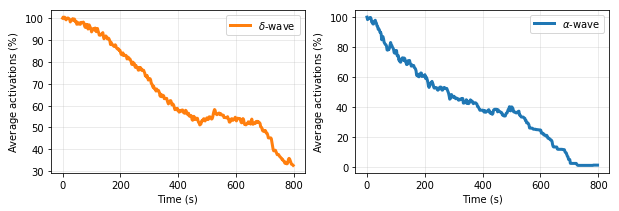

In [9]:
# Decreasing of the theta and alpha waves

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(t1[:-99], 100*moving_average(Z_time[0, :, 1])/moving_average(Z_time[0, :, 1])[0], lw=3, color='C1', label=('$\\delta$-wave'))
plt.grid(alpha=.3)
plt.xlabel('Time (s)')
plt.ylabel('Average activations ($\%$)')
plt.legend(loc=1)

plt.subplot(122)
plt.plot(t1[:-99], 100*moving_average(Z_time[2, :, 0])/np.max(moving_average(Z_time[2, :, 0])), lw=3, color='C0', label=('$\\alpha$-wave'))
plt.grid(alpha=.3)
plt.xlabel('Time (s)')
plt.ylabel('Average activations ($\%$)')
plt.legend(loc=1)